# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# Chapitre 6 : Régression linéaire bayésienne

Dans ce chapitre, nous utiliserons le jeu de données *bloopressure.csv* disponible sur le site web du cours. La variable d'intérêt est la tension artérielle (*blood pressure*) mesurée en *mm* de mercure. Les 6 variables explicatives suivantes sont proposées :

- âge en années ($x_1$ = age) ; 
- masse en $kg$ ($x_2$ = Weight) ;
- surface corporelle en $m^2$ ($x_3$ = BSA) ;
- durée de l'hypertension en années ($x_4$ = Dur) ;
- pouls basal en battements par minute ($x_5$ = Pulse) ;
- niveau de stress de 0 à 100 ($x_6$ = Stress).

In [1]:
# Chargement des librairies nécessaires

using CSV, DataFrames, LinearAlgebra, Statistics, Distributions
using Compose, Gadfly

In [2]:
"""
    standardize!(X::AbstractMatrix)

Standardisation du vecteur colonne X ou de chacune des colonnes de la matrice X.

### Arguments
- `X::Matrix{Real}` : Vecteur ou matrice à standardiser.

### Détails

La fonction centre la matrice et modifie l'échelle de l'argument X.

### Exemples

\```
 julia> standardize!(X)
\```

"""
function standardize!(x::Vector{Float64})
    
    x̄ = mean(x)
    s = std(x)
    
    for i=1:length(x)
        x[i] = (x[i] - x̄)/s
    end
    
    return x
    
end

function standardize!(X::Matrix{Float64})
    
    for j=1:size(X,2)
       X[:,j] = standardize!(X[:,j])
    end
    
    return X
    
end

function softmax(x::AbstractVector{<:Real})
    
    z = x .- maximum(x)
    
    e = exp.(z)
    
    s = e ./ sum(e)
    
end

softmax (generic function with 1 method)

## 6.2  Régression linéaire bayésienne avec loi a priori non informative

Dans cette section, nous n'utiliserons que deux variables explicatives pour expliquer la tension artérielle, soit l'âge et la masse. Puisque toutes les variables seront standardisées, l'ordonnée à l'origine du modèle n'est pas nécessaire.

In [3]:
# Chargement des données

data = CSV.read("bloodpressure.csv")
first(data,5)

,Pt,BP,Age,Weight,BSA,Dur,Pulse,Stress
,Int64,Int64,Int64,Float64,Float64,Float64,Int64,Int64
1,1,105,47,85.4,1.75,5.1,63,33
2,2,115,49,94.2,2.1,3.8,70,14
3,3,116,49,95.3,1.98,8.2,72,10
4,4,117,50,94.7,2.01,5.8,73,99
5,5,112,51,89.4,1.89,7.0,72,95


In [4]:
# Traitement des données

y = convert(Array{Float64},data[:,:BP])
standardize!(y)

X = convert(Matrix{Float64},data[:,[:Age, :Weight]])
n, p = size(X)
standardize!(X)

20×2 Array{Float64,2}:
 -0.639865  -1.79049  
  0.159966   0.258446 
  0.159966   0.514563 
  0.559882   0.374863 
  0.959798  -0.859158 
 -0.239949   1.49247  
  0.159966   1.56232  
 -0.639865  -0.509906 
  0.159966  -0.905724 
 -0.239949  -0.0908053
 -0.639865   0.305013 
  0.159966   0.235162 
  0.559882  -0.346923 
 -1.4397    -1.39468  
  1.35971    1.91157  
 -1.03978    0.328296 
 -1.03978   -1.41796  
 -1.03978    0.328296 
 -0.239949  -0.60304  
  2.95938    0.607697 

### Estimation par les moindres carrés

In [5]:
β̂ = (X'X)\X'y

2-element Array{Float64,1}:
 0.32621331782769525
 0.8171848975986987 

### Estimation bayésienne avec loi *a priori* impropre

La loi *a priori* utilisée est la suivante

$$f_{(\boldsymbol{\beta},\sigma^2)}(\boldsymbol{\beta},\sigma^2) \propto \frac{1}{\sigma^2}.$$

Implémentation de l'échantillonnage de Gibbs pour obtenir un échantillon de la loi *a posteriori* des paramètres. Dans l'implémentation, pour éviter d'inverser la matrice $(X'X)$, la paramétrisation canonique de la loi normale est utilisée. Ce n'est pas nécessaire que vous implémentiez cette forme, c'est pour vous montrer comment c'est fait en pratique.

In [6]:
# Implémentation de l'échantillonnage de Gibbs

m = 1000
β = zeros(p,m)
σ² = ones(m);

for i=2:m
    
    J = (X'X)/σ²[i-1]
    h = J*β̂
    β[:,i] = rand(MvNormalCanon(h, J))
    
    e = y - X*β[:,i]
    s = dot(e,e)
    
    σ²[i] = rand(InverseGamma(n/2, s/2))
    
end

# Stockage des résultats dans un dataframe pour un affichage rapide avec la librairie Gadfly
MCMC = DataFrame(Itération = 1:m, β₁ = β[1,:], β₂ = β[2,:], σ² = σ²);

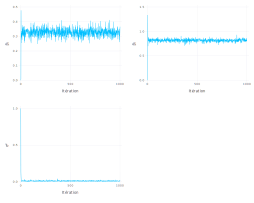

In [7]:
# Affichage de la chaîne générée

fig1 = plot(MCMC, x=:Itération, y=:β₁, Geom.line)
fig2 = plot(MCMC, x=:Itération, y=:β₂, Geom.line)
fig3 = plot(MCMC, x=:Itération, y=:σ², Geom.line)

set_default_plot_size(10inch, 8inch)
gridstack(Union{Plot,Compose.Context}[fig1 fig2; fig3 Compose.context()])

In [8]:
# Rejetons les 100 premières itérations, considérées ici comme la phase de chauffe

deleterows!(MCMC, 1:100)

,Itération,β₁,β₂,σ²
,Int64,Float64,Float64,Float64
1,101,0.343826,0.829119,0.0161521
2,102,0.264076,0.8163,0.0314188
3,103,0.391857,0.721692,0.025701
4,104,0.253424,0.881224,0.0123141
5,105,0.293635,0.866146,0.0101831
6,106,0.361566,0.780498,0.00880784
7,107,0.306284,0.823719,0.0115405
8,108,0.325597,0.846237,0.00911524
9,109,0.334267,0.822496,0.00814764


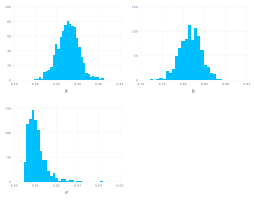

In [9]:
# Affichage des distributions marginales

fig1 = plot(MCMC, x=:β₁, Geom.histogram(bincount=30))
fig2 = plot(MCMC, x=:β₂, Geom.histogram(bincount=30))
fig3 = plot(MCMC, x=:σ², Geom.histogram(bincount=30))

set_default_plot_size(10inch, 8inch)
gridstack(Union{Plot,Compose.Context}[fig1 fig2; fig3 Compose.context()])

### Lois *a posteriori* marginales

Il est possible de trouver la forme analytique des lois *a posteriori* marginales des paramètres.

In [10]:
e = y-X*β̂
s² = dot(e,e)/(n-p)
Σ = s²*inv(X'X)

2×2 Array{Float64,2}:
  0.000573772  -0.000233726
 -0.000233726   0.000573772

In [11]:
β₁_dist = LocationScale(β̂[1],sqrt(Σ[1,1]),TDist(n-p))
β₂_dist = LocationScale(β̂[2],sqrt(Σ[2,2]),TDist(n-p))

# b = y'*(I-H)*y
σ²_dist = InverseGamma((n-p)/2,(n-p)*s²/2)

InverseGamma{Float64}(
invd: Gamma{Float64}(α=9.0, θ=12.21978944989757)
θ: 0.08183447056106047
)


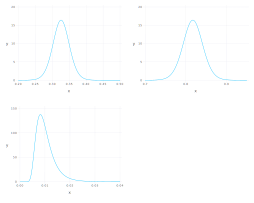

In [12]:
x = range(.2, stop=.5, length=1000)
fig1 =plot(x=x, y=pdf.(β₁_dist,x), Geom.line, Coord.cartesian(xmin=minimum(x), xmax=maximum(x)))

x = range(.7, stop=.95, length=1000)
fig2 =plot(x=x, y=pdf.(β₂_dist,x), Geom.line, Coord.cartesian(xmin=minimum(x), xmax=maximum(x)))

x = range(0, stop=.04, length=1000)
fig3 =plot(x=x, y=pdf.(σ²_dist,x), Geom.line, Coord.cartesian(xmin=minimum(x), xmax=maximum(x)))

set_default_plot_size(10inch, 8inch)
gridstack(Union{Plot,Compose.Context}[fig1 fig2; fig3 Compose.context()])

## 6.3  Régression linéaire bayésienne avec loi a priori partiellement informative

Puisque toutes les variables seront standardisées, l'ordonnée à l'origine du modèle n'est pas nécessaire.

In [13]:
# Chargement des données

data = CSV.read("bloodpressure.csv")
first(data,5)

,Pt,BP,Age,Weight,BSA,Dur,Pulse,Stress
,Int64,Int64,Int64,Float64,Float64,Float64,Int64,Int64
1,1,105,47,85.4,1.75,5.1,63,33
2,2,115,49,94.2,2.1,3.8,70,14
3,3,116,49,95.3,1.98,8.2,72,10
4,4,117,50,94.7,2.01,5.8,73,99
5,5,112,51,89.4,1.89,7.0,72,95


In [14]:
# Traitement des données

y = convert(Array{Float64},data[:,:BP])
standardize!(y)

X = convert(Matrix{Float64},data[:,3:end])
n, p = size(X)
standardize!(X)

20×6 Array{Float64,2}:
 -0.639865  -1.79049    -1.81709    -0.619967  -1.73545   -0.548719
  0.159966   0.258446    0.747351   -1.22595    0.105179  -1.06104 
  0.159966   0.514563   -0.131885    0.825069   0.631073  -1.16889 
  0.559882   0.374863    0.0879236  -0.293668   0.89402    1.23091 
  0.959798  -0.859158   -0.791312    0.2657     0.631073   1.12305 
 -0.239949   1.49247     1.8464      1.33782    0.368126  -1.16889 
  0.159966   1.56232     1.8464     -1.83193   -0.157768  -0.306043
 -0.639865  -0.509906   -0.718043   -0.107212  -0.94661   -1.22282 
  0.159966  -0.905724   -1.23093     0.312314  -0.157768   0.233239
 -0.239949  -0.0908053   0.527542   -0.386897  -1.4725    -0.494791
 -0.639865   0.305013    0.527542   -0.526739   1.15697    0.988234
  0.159966   0.235162   -0.131885   -0.386897   0.368126  -0.872289
  0.559882  -0.346923    0.381002    1.75735   -0.420715  -0.171222
 -1.4397    -1.39468    -0.571503   -0.386897  -0.683663   0.718593
  1.35971    1.91157     

In [15]:
function estimateridge(y::Vector{<:Real},X::Matrix{<:Real}, λ::Real)
   
    @assert λ>=0
    
    β̂_Ridge = (X'X +λ*I)\X'y
    
    return β̂_Ridge
    
end

estimateridge (generic function with 1 method)

In [16]:
df = DataFrame(λ = Float64[], β₁ = Float64[], β₂ = Float64[], β₃ = Float64[], β₄ = Float64[], β₅ = Float64[], β₆ = Float64[])

for λ in 0:.001:10
    
    β̂ = estimateridge(y, X, λ)
    
    push!(df, [λ, β̂...])
    
end

In [25]:
trace = stack(df, Not(:λ))
rename!(trace, :variable => :Paramètre, :value => :Estimation)
first(trace,5)

,Paramètre,Estimation,λ
,Symbol,Float64,Float64
1,β₁,0.323914,0.0
2,β₁,0.323856,0.001
3,β₁,0.323798,0.002
4,β₁,0.32374,0.003
5,β₁,0.323682,0.004


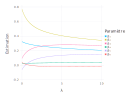

In [18]:
set_default_plot_size(5inch, 4inch)
plot(trace, x=:λ, y=:Estimation, color=:Paramètre, Geom.line)

### 6.3 Sélection de modèle

In [19]:
itr = reverse.(Iterators.product(fill(0:1,p)...))[:]

γ = zeros(Int64,length(itr),p)
for i in eachindex(itr)
   γ[i,:] = [itr[i]...]
end
γ

64×6 Array{Int64,2}:
 0  0  0  0  0  0
 0  0  0  0  0  1
 0  0  0  0  1  0
 0  0  0  0  1  1
 0  0  0  1  0  0
 0  0  0  1  0  1
 0  0  0  1  1  0
 0  0  0  1  1  1
 0  0  1  0  0  0
 0  0  1  0  0  1
 0  0  1  0  1  0
 0  0  1  0  1  1
 0  0  1  1  0  0
 ⋮              ⋮
 1  1  0  1  0  0
 1  1  0  1  0  1
 1  1  0  1  1  0
 1  1  0  1  1  1
 1  1  1  0  0  0
 1  1  1  0  0  1
 1  1  1  0  1  0
 1  1  1  0  1  1
 1  1  1  1  0  0
 1  1  1  1  0  1
 1  1  1  1  1  0
 1  1  1  1  1  1

In [20]:
itr = reverse.(Iterators.product(fill(0:1,p)...))[:]

γ = BitArray[]
for i in eachindex(itr)
   push!(γ, [itr[i]...] .== 1)
end
γ

64-element Array{BitArray,1}:
 [0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 1]
 [0, 0, 0, 0, 1, 0]
 [0, 0, 0, 0, 1, 1]
 [0, 0, 0, 1, 0, 0]
 [0, 0, 0, 1, 0, 1]
 [0, 0, 0, 1, 1, 0]
 [0, 0, 0, 1, 1, 1]
 [0, 0, 1, 0, 0, 0]
 [0, 0, 1, 0, 0, 1]
 [0, 0, 1, 0, 1, 0]
 [0, 0, 1, 0, 1, 1]
 [0, 0, 1, 1, 0, 0]
 ⋮                 
 [1, 1, 0, 1, 0, 0]
 [1, 1, 0, 1, 0, 1]
 [1, 1, 0, 1, 1, 0]
 [1, 1, 0, 1, 1, 1]
 [1, 1, 1, 0, 0, 0]
 [1, 1, 1, 0, 0, 1]
 [1, 1, 1, 0, 1, 0]
 [1, 1, 1, 0, 1, 1]
 [1, 1, 1, 1, 0, 0]
 [1, 1, 1, 1, 0, 1]
 [1, 1, 1, 1, 1, 0]
 [1, 1, 1, 1, 1, 1]

In [21]:
X[:,γ[6]]

20×2 Array{Float64,2}:
 -0.619967  -0.548719
 -1.22595   -1.06104 
  0.825069  -1.16889 
 -0.293668   1.23091 
  0.2657     1.12305 
  1.33782   -1.16889 
 -1.83193   -0.306043
 -0.107212  -1.22282 
  0.312314   0.233239
 -0.386897  -0.494791
 -0.526739   0.988234
 -0.386897  -0.872289
  1.75735   -0.171222
 -0.386897   0.718593
  1.66412    1.20395 
  0.452156   1.12305 
 -1.31918   -0.953181
 -0.992879  -1.11497 
  1.19798    1.23091 
  0.2657     1.23091 

In [22]:
function getbic(γ::BitArray)
   
    Z = X[:,γ]
    
    n, p = size(Z)
    
    if p>0
    
        β̂ = (Z'Z)\Z'y
        e = (y-Z*β̂)
    
        σ̂² = dot(e,e)/(n-p)
    
        BIC = sum(logpdf.(Normal.(Z*β̂, sqrt(σ̂²)),y)) - (p+1)/2 * log(n)
        
    else
        
        σ̂² = dot(y,y)/n
        
        BIC = sum(logpdf.(Normal.(0, sqrt(σ̂²)),y)) - 1/2 * log(n)
        
    end
    
    return BIC
    
    
end

getbic (generic function with 1 method)

In [23]:
b = zeros(length(γ))
for i=1:length(γ)
    b[i] = getbic(γ[i])
end

_, ind = findmax(b)
γ[ind]

6-element BitArray{1}:
 1
 1
 1
 0
 0
 0

In [24]:
# il faudrait faire l'échantillonnage de Gibbs et reconnaître le modèle à chacune des itérations.